In [1]:
import uproot
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib import rcParams

tf.random.set_seed(42)

In [50]:
filename = "tracksters_ds_pion.root"
tracksters = uproot.open({filename: "tracksters"})

In [51]:
tracksters.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nvertices_x          | int32_t                  | AsDtype('>i4')
vertices_x           | double[]                 | AsJagged(AsDtype('>f8'))
nvertices_y          | int32_t                  | AsDtype('>i4')
vertices_y           | double[]                 | AsJagged(AsDtype('>f8'))
nvertices_z          | int32_t                  | AsDtype('>i4')
vertices_z           | double[]                 | AsJagged(AsDtype('>f8'))
nvertices_energy     | int32_t                  | AsDtype('>i4')
vertices_energy      | double[]                 | AsJagged(AsDtype('>f8'))
nvertices_indexes    | int32_t                  | AsDtype('>i4')
vertices_indexes     | int64_t[]                | AsJagged(AsDtype('>i8'))
trackster_label      | int64_t                  | AsDtype('>i8')
trackster_event      | int64_t                  | AsDtype('>i8')


In [82]:
nx = tracksters["nvertices_x"].array()
ce = tracksters["vertices_energy"].array()
cl = tracksters["trackster_label"].array()

In [83]:
e_sum = np.array([sum(x) for x in ce])

In [84]:
x = np.array(np.vstack((nx, e_sum))).T


In [85]:
X_train, X_test, y_train, y_test = train_test_split(
 x, cl, test_size=0.2, random_state=np.random.randint(0,100))

In [86]:
print(len(X_train), len(X_test))

44870 11218


In [87]:
scaler = StandardScaler()
x_train = scaler.fit_transform(np.array(X_train))
x_test = scaler.transform(np.array(X_test))

In [88]:
model = tf.keras.Sequential([
    # tf.keras.layers.Dense(5, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [89]:
epochs = 5
history = model.fit(x_train, np.array(y_train), epochs=epochs)

Epoch 1/5
   8/1403 [..............................] - ETA: 11s - loss: 0.8306 - accuracy: 0.5352 - precision: 0.0342 - recall: 0.4000         

2022-06-27 14:03:53.779049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1403/1403 [==============================] - 11s 8ms/step - loss: 0.5796 - accuracy: 0.8157 - precision: 0.1458 - recall: 0.3756
Epoch 2/5
1403/1403 [==============================] - 11s 8ms/step - loss: 0.2357 - accuracy: 0.9409 - precision: 0.5431 - recall: 0.5999
Epoch 3/5
1403/1403 [==============================] - 11s 8ms/step - loss: 0.1154 - accuracy: 0.9766 - precision: 0.8522 - recall: 0.7757
Epoch 4/5
1403/1403 [==============================] - 11s 8ms/step - loss: 0.0709 - accuracy: 0.9838 - precision: 0.9288 - recall: 0.8146
Epoch 5/5
1403/1403 [==============================] - 12s 8ms/step - loss: 0.0517 - accuracy: 0.9859 - precision: 0.9385 - recall: 0.8389


In [90]:
rcParams['figure.figsize'] = (14, 6)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

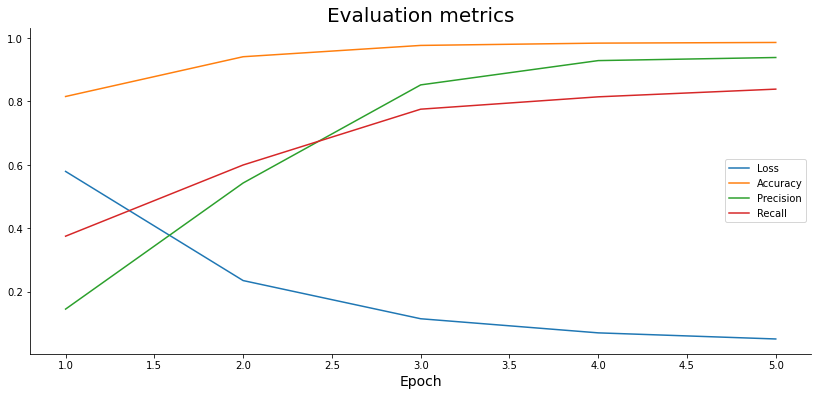

In [91]:
plt.plot(
    np.arange(1, epochs + 1), 
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, epochs + 1), 
    history.history['accuracy'], label='Accuracy'
)
plt.plot(
    np.arange(1, epochs + 1), 
    history.history['precision'], label='Precision'
)
plt.plot(
    np.arange(1, epochs + 1), 
    history.history['recall'], label='Recall'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()

In [92]:
predictions = model.predict(x_test)

 62/351 [====>.........................] - ETA: 0s

2022-06-27 14:04:49.089822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


351/351 [==============================] - 1s 2ms/step


In [93]:
prediction_classes = [
    1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
]

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, prediction_classes))

from sklearn.metrics import accuracy_score, precision_score, recall_score

print(f'Accuracy: {accuracy_score(y_test, prediction_classes):.4f}')
print(f'Precision: {precision_score(y_test, prediction_classes):.4f}')
print(f'Recall: {recall_score(y_test, prediction_classes):.4f}')


[[10448    39]
 [  131   600]]
Accuracy: 0.9848
Precision: 0.9390
Recall: 0.8208


In [94]:
pred = [int(np.round(predictions)[i][0]) for i in range(len(predictions))]

In [102]:
def check_accuracy(predictions, labels, x):
    e_nvertices = x.T[0]
    e_sum = x.T[1]
    plt.figure(figsize=(10, 8))
    mask11 = (np.array(predictions) == 1) & (np.array(labels) == 1)
    plt.scatter(e_nvertices[mask11], e_sum[mask11], c = 'dodgerblue', label = 'correct, complete', s=3) 
    mask01 = (np.array(predictions) == 0) & (np.array(labels) == 1)
    plt.scatter(e_nvertices[mask01], e_sum[mask01], c = 'lawngreen', label = 'incorrect (predicted incomplete)', s=10) 
    mask10 = (np.array(predictions) == 1) & (np.array(labels) == 0)
    plt.scatter(e_nvertices[mask10], e_sum[mask10], c = 'forestgreen', label = 'incorrect (predicted complete)', s=10) 
    #print(np.where(mask10==True))
    mask00 = (np.array(predictions) == 0) & (np.array(labels) == 0)
    plt.scatter(e_nvertices[mask00], e_sum[mask00], c = 'darkblue', label = 'correct, incomplete', s=3) 

    plt.title("Number of vertices vs total energy")
    plt.xlabel("Number of vertices")
    plt.ylabel("Total energy")
    plt.yscale('log')
    plt.legend()
    return

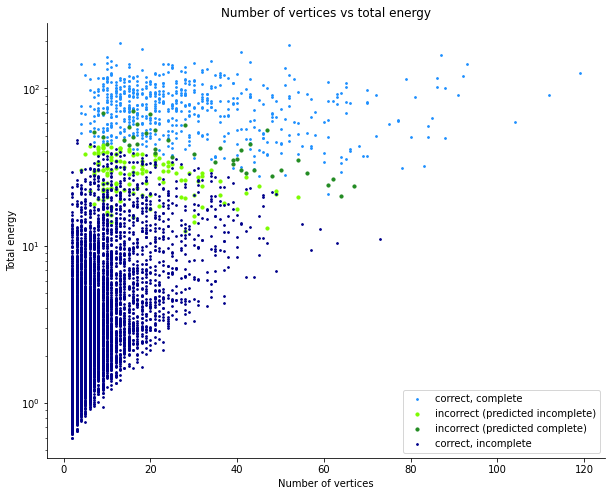

In [103]:
check_accuracy(pred, y_test, X_test)

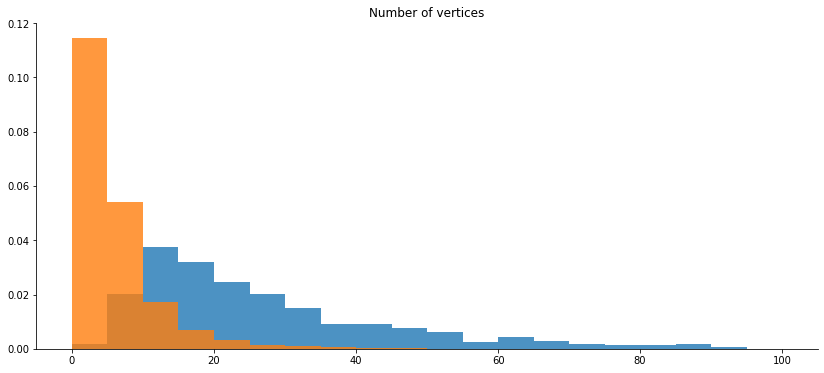

In [105]:
mask = np.array(y_test).astype(bool)
pos = X_test[mask].T[0]
plt.hist(pos, bins=20, alpha=0.8, density=True, range=(0, 100))

mask2 = np.array(y_test).astype(bool) == False
neg = X_test[mask2].T[0]
plt.hist(neg, bins=20, alpha=0.8, density=True, range=(0, 100))
plt.title("Number of vertices")
pass

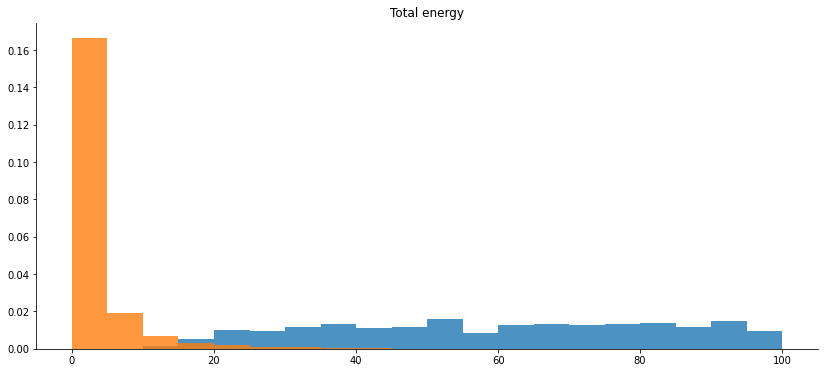

In [106]:
mask = np.array(y_test).astype(bool)
pos = X_test[mask].T[1]
plt.hist(pos, bins=20, alpha=0.8, density=True, range=(0, 100))

mask2 = np.array(y_test).astype(bool) == False
neg = X_test[mask2].T[1]
plt.hist(neg, bins=20, alpha=0.8, density=True, range=(0, 100))
plt.title("Total energy")
pass